In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from portfoliolab.utils import RiskMetrics
from portfoliolab.estimators import RiskEstimators, ReturnsEstimators

In [3]:
from pyfinlab import data_api as api
from pyfinlab import risk_models as rm

Choose start and end dates

In [4]:
start_date = (datetime.today() - timedelta(days=365*10)).strftime('%Y-%m-%d')
end_date = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')

Choose portfolio tickers and weightings % for three-asset portfolio

In [5]:
tickers = ['SPY', 'AGG', 'GLD']
weights = np.array([0.34, .33, 0.33]) # asset portfolio weightings
if weights.sum()!=1.: raise ValueError('Your weights do not equal 100%') 
else: print('Total Weightings: {}%'.format(weights.sum()*100))

Total Weightings: 100.0%


Download price data and compute returns

In [6]:
prices = api.price_history(tickers, start_date, end_date, api_source='yfinance')

[*********************100%***********************]  3 of 3 completed


In [7]:
returns = prices.pct_change().dropna()

## Portfolio Volatility Computed Using Each Risk Model

In [8]:
kde_bwidth = 0.01
basic_shrinkage = 0.1
covs = rm.covariance_loop(prices, kde_bwidth, basic_shrinkage)
vols = rm.volatility_loop(covs, weights)
vols

The average portfolio volatility using all price data as one sample: 0.071196


targeted_shrinkage_detoned                0.090736
constant_residual_detoned                 0.086031
sample_covariance                         0.080890
shrinked_covariance_lw                    0.080782
shrinked_covariance_basic                 0.080665
shrinked_covariance_oas                   0.080602
empirical_covariance                      0.080591
hierarchical_filtered_complete            0.079897
hierarchical_filtered_avg                 0.079186
hierarchical_filtered_single              0.078469
constant_residual_eigenvalues_denoised    0.078161
targeted_shrinkage_denoised               0.077541
exponential_covariance                    0.067277
minimum_covariance_determinant            0.051142
semi_covariance                           0.039310
constant_residual_spectral_denoised       0.007854
Name: Annualized Volatility, dtype: float64

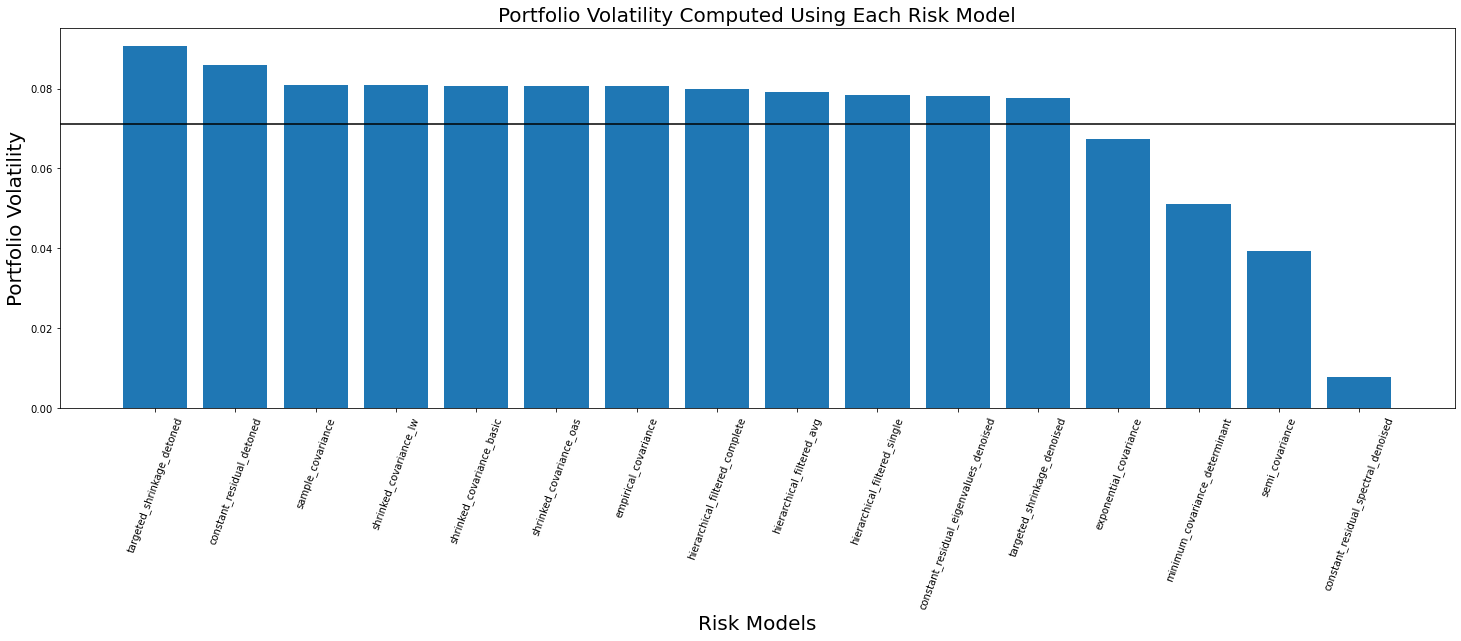

In [9]:
y_pos = np.arange(len(vols.index))
plt.figure(figsize=(25,7))
plt.bar(list(vols.index), vols.values)
plt.axhline(vols.mean(), color='black')
plt.xticks(y_pos, rotation=70, size=10)
plt.xlabel('Risk Models', size=20)
plt.ylabel('Portfolio Volatility', size=20)
plt.title('Portfolio Volatility Computed Using Each Risk Model', size=20)
plt.show()

## Out-of-Sample Test

The following code splits time series daily price data into sub-samples. Each risk model's covariance matrix of each
sub-sample is compared to the empirical covariance matrix of the next sequential sub-sample. The forecast error is measured 
by the Sum of Squared Errors (SSE) and averaged together for each risk model. The risk model with the lowest average
SSE is hypothetically the best risk model because it apparently had the lowest forecast error. 

In [10]:
subsample_size = 125 # days
num_of_samples = int(prices.shape[0] / subsample_size) # how many times to split sample

In [11]:
split_sample = rm.split_sample(prices, num_of_samples, 'empirical_covariance') 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 94.99it/s]

Sub-sample size: 125 days
Number of samples: 20


In [12]:
sum_squared_errors = rm.compute_sse(split_sample)

 16%|██████████████████████████████████████▋                                                                                                                                                                                                              | 3/19 [00:00<00:02,  6.43it/s]C:\Users\25del\AppData\Roaming\Python\Python38\site-packages\portfoliolab\estimators\risk_estimators.py:675: RuntimeWarning: invalid value encountered in double_scalars
  eigenval_vec[num_facts:] = eigenval_vec[num_facts:].sum() / float(eigenval_vec.shape[0] - num_facts)
C:\Users\25del\AppData\Roaming\Python\Python38\site-packages\portfoliolab\estimators\risk_estimators.py:675: RuntimeWarning: invalid value encountered in double_scalars
  eigenval_vec[num_facts:] = eigenval_vec[num_facts:].sum() / float(eigenval_vec.shape[0] - num_facts)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

In [13]:
sse_averages = rm.sse_average(sum_squared_errors)
sse_averages

Risk model with the lowest mean sum of squared error: minimum_covariance_determinant


,mean_sum_squared_error
minimum_covariance_determinant,0.370932
semi_covariance,0.425657
exponential_covariance,0.484205
shrinked_covariance_lw,0.573032
shrinked_covariance_basic,0.580585
shrinked_covariance_oas,0.598173
empirical_covariance,0.614492
constant_residual_eigenvalues_denoised,0.614492
constant_residual_spectral_denoised,0.614492
targeted_shrinkage_denoised,0.614492


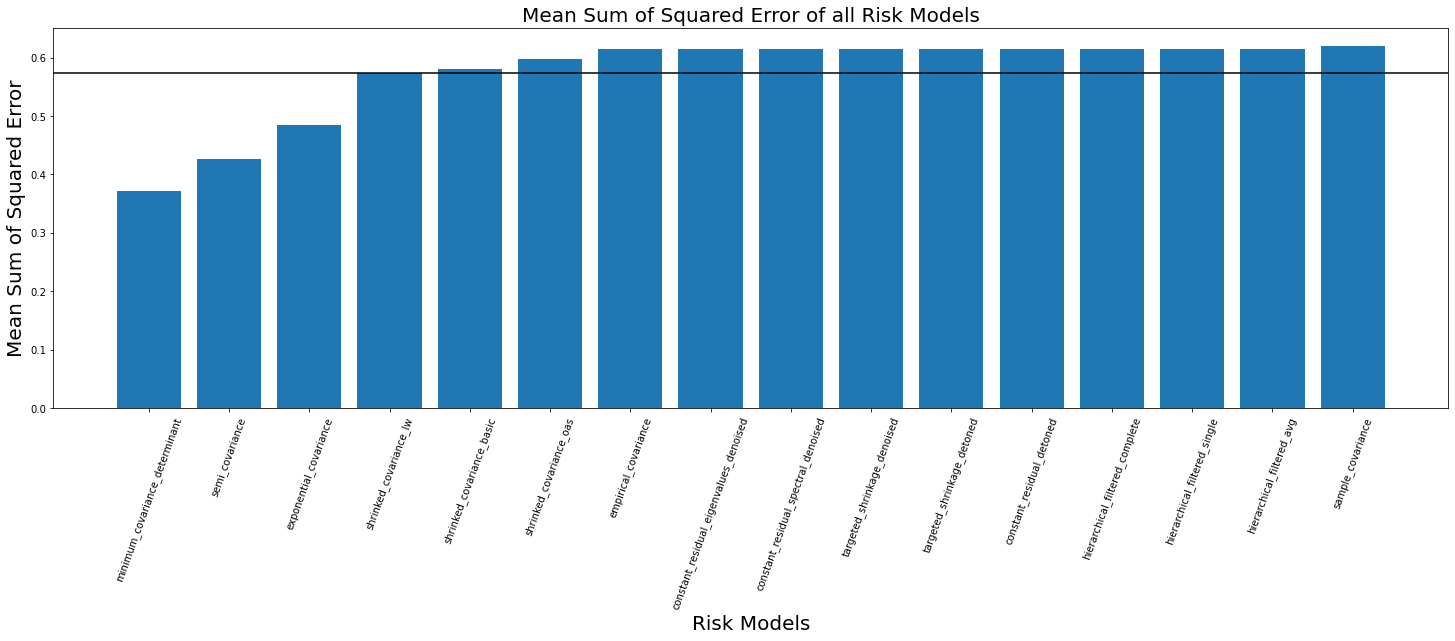

In [14]:
y_pos = np.arange(len(sse_averages.index))
plt.figure(figsize=(25,7))
plt.bar(list(sse_averages.index), sse_averages.squeeze().values)
plt.axhline(sse_averages.squeeze().mean(), color='black')
plt.xticks(y_pos, rotation=70, size=10)
plt.xlabel('Risk Models', size=20)
plt.ylabel('Mean Sum of Squared Error', size=20)
plt.title('Mean Sum of Squared Error of all Risk Models', size=20)
plt.show()

In [15]:
win_count = rm.win_count(sum_squared_errors)

The risk model with the most months with the lowest mean SSE: minimum_covariance_determinant
                                        Win Count
minimum_covariance_determinant                  6
sample_covariance                               5
shrinked_covariance_lw                          2
semi_covariance                                 2
exponential_covariance                          2
empirical_covariance                            1
shrinked_covariance_basic                       0
shrinked_covariance_oas                         0
constant_residual_eigenvalues_denoised          0
constant_residual_spectral_denoised             0
targeted_shrinkage_denoised                     0
targeted_shrinkage_detoned                      0
constant_residual_detoned                       0
hierarchical_filtered_complete                  0
hierarchical_filtered_single                    0
hierarchical_filtered_avg                       0


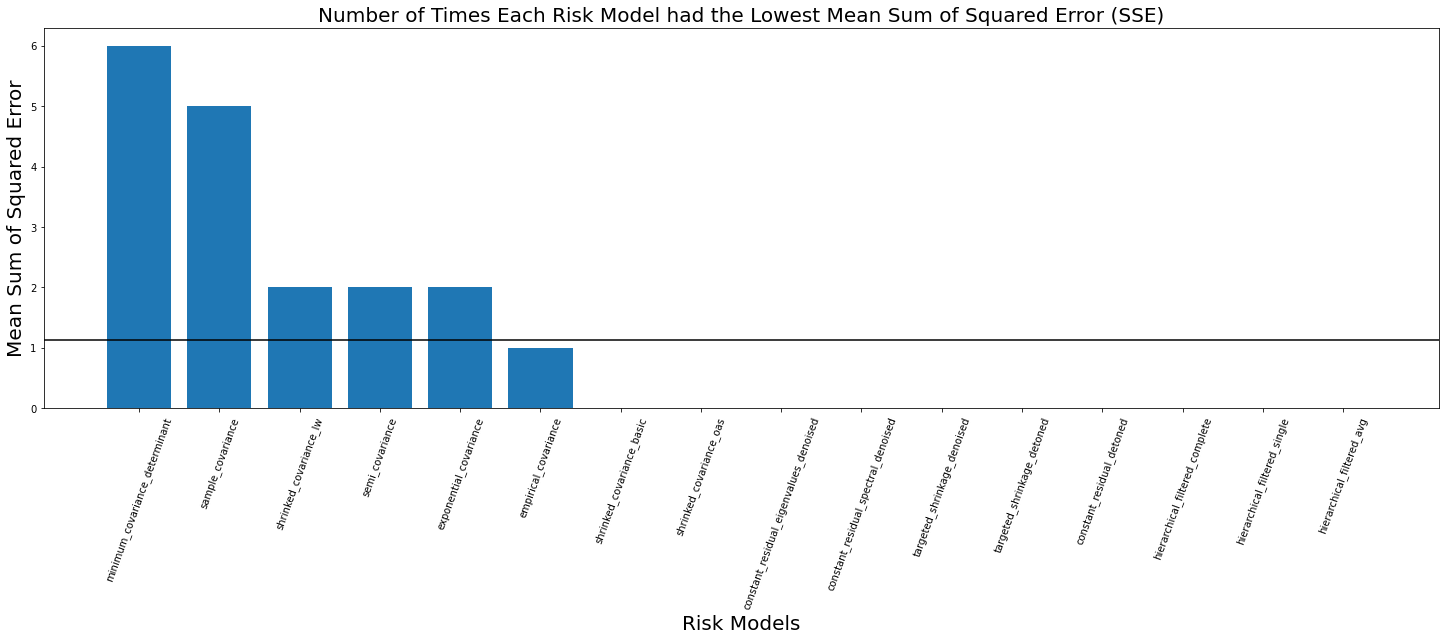

In [16]:
y_pos = np.arange(len(win_count.index))
plt.figure(figsize=(25,7))
plt.bar(list(win_count.index), win_count.squeeze().values)
plt.axhline(win_count.squeeze().mean(), color='black')
plt.xticks(y_pos, rotation=70, size=10)
plt.xlabel('Risk Models', size=20)
plt.ylabel('Mean Sum of Squared Error', size=20)
plt.title('Number of Times Each Risk Model had the Lowest Mean Sum of Squared Error (SSE)', size=20)
plt.show()